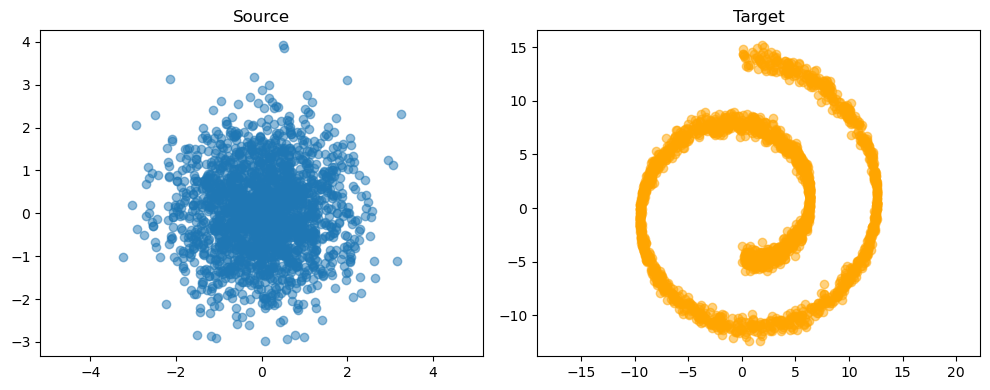

In [2]:
# 1. Imports
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from torchdiffeq import odeint
import random
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(42)

# 2. Data Generation (shared)

def sample_standard_gaussian(n_samples=1000):
    return np.random.randn(n_samples, 2).astype(np.float32)

def sample_swiss_roll(n_samples=1000):
    t = 1.5 * np.pi * (1 + 2 * np.random.rand(n_samples))
    x = t * np.cos(t)
    y = t * np.sin(t)
    noise = 0.5 * np.random.randn(n_samples)
    return np.stack([x, y + noise], axis=1).astype(np.float32)

def sample_star_distribution(n_samples=1000, arms=5):
    angles = np.random.choice(np.linspace(0, 2*np.pi, arms, endpoint=False), n_samples)
    r = 2 + 0.3 * np.random.randn(n_samples)
    x = r * np.cos(angles) + 0.1 * np.random.randn(n_samples)
    y = r * np.sin(angles) + 0.1 * np.random.randn(n_samples)
    return np.stack([x, y], axis=1).astype(np.float32)

def sample_gaussian_mixture(n_samples=1000):
    centers = [np.array([-2.0, 0.0]), np.array([2.0, 0.0])]
    samples = []
    for _ in range(n_samples):
        center = centers[np.random.choice([0, 1])]
        noise = np.random.randn(2) * 0.2
        samples.append(center + noise)
    return np.array(samples, dtype=np.float32)

source_np = sample_standard_gaussian(2000)
target_np = sample_swiss_roll(2000)
# target_np = sample_gaussian_mixture(1000)
# source_np = sample_swiss_roll(1000)
# target_np = sample_standard_gaussian(1000)

# Visualize source and target samples
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(source_np[:, 0], source_np[:, 1], alpha=0.5)
plt.title("Source")
plt.axis("equal")

plt.subplot(1, 2, 2)
plt.scatter(target_np[:, 0], target_np[:, 1], alpha=0.5, color='orange')
plt.title("Target")
plt.axis("equal")

plt.tight_layout()
plt.show()

In [3]:
# Re-import after kernel reset
from scipy.linalg import sqrtm
from scipy.stats import wasserstein_distance

# Redefine metrics
def frechet_distance(X_gen, X_real):
    mu_gen = np.mean(X_gen, axis=0)
    mu_real = np.mean(X_real, axis=0)
    cov_gen = np.cov(X_gen, rowvar=False)
    cov_real = np.cov(X_real, rowvar=False)
    covmean = sqrtm(cov_gen @ cov_real)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    diff = mu_gen - mu_real
    return diff @ diff + np.trace(cov_gen + cov_real - 2 * covmean)

def wasserstein_2d(X_gen, X_real):
    d1 = wasserstein_distance(X_gen[:, 0], X_real[:, 0])
    d2 = wasserstein_distance(X_gen[:, 1], X_real[:, 1])
    return (d1 + d2) / 2


In [4]:
# Convert to Torch tensors
source_data = torch.tensor(source_np).to(device)
target_data = torch.tensor(target_np).to(device)
dataset = TensorDataset(source_data, target_data)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)


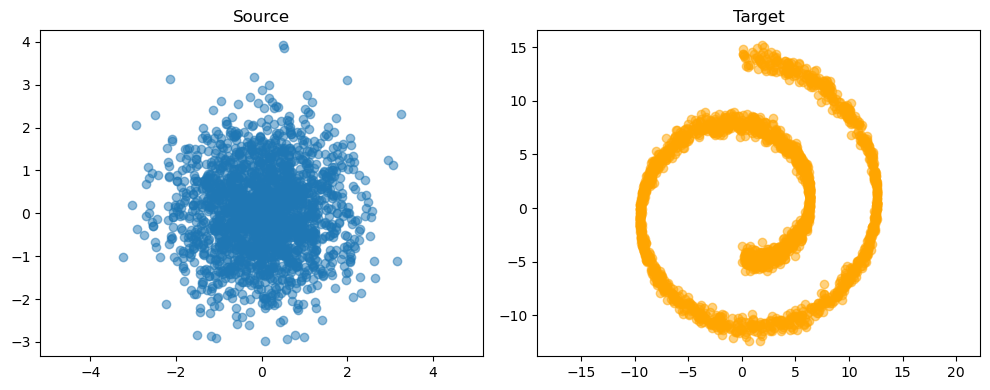

In [5]:

# 可视化 source 和 target 分布
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(source_np[:, 0], source_np[:, 1], alpha=0.5)
plt.title("Source")
plt.axis("equal")

plt.subplot(1, 2, 2)
plt.scatter(target_np[:, 0], target_np[:, 1], alpha=0.5, color='orange')
plt.title("Target")
plt.axis("equal")

plt.tight_layout()
plt.show()


In [6]:
# 4. CNF (ODE-based Flow)
class CNFNet(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, t, x):
        t_expand = t.expand_as(x[:, :1])
        xt = torch.cat([x, t_expand], dim=1)
        return self.net(xt)

# 6. CNF Training (Log-likelihood Based)

# Helper: log probability of standard Gaussian

def standard_normal_logprob(z):
    return -0.5 * (z.pow(2) + np.log(2 * np.pi)).sum(dim=1)

# CNF with Hutchinson trace estimation
def trace_df_dx(f, x, t):
    e = torch.randn_like(x)  # random vector for Hutchinson estimator
    e_dz = torch.autograd.grad(f(t, x), x, e, create_graph=True)[0]
    return (e_dz * e).sum(dim=1)

def train_cnf(model, data, epochs=100, lr=1e-3, batch_size=256, method="rk4"):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    num_samples = data.shape[0]
    num_batches = (num_samples + batch_size - 1) // batch_size

    for epoch in range(epochs):
        perm = torch.randperm(num_samples)
        for i in range(num_batches):
            idx = perm[i * batch_size: (i + 1) * batch_size]
            x_T = data[idx].clone().detach().requires_grad_(True)
            logp_T = torch.zeros(x_T.shape[0], device=x_T.device)

            def odefunc(t, state):
                x, logp = state
                dx = model(t, x)
                dlogp = -trace_df_dx(model, x, t)
                return dx, dlogp

            t_vals = torch.tensor([1.0, 0.0], device=x_T.device)
            (z_0, delta_logp) = odeint(odefunc, (x_T, logp_T), t_vals, method=method, options={"step_size": 0.1}, atol=1e-5, rtol=1e-5)

            logp_0 = standard_normal_logprob(z_0[-1])
            logp_x = logp_0 - delta_logp[-1]
            loss = -logp_x.mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0:
            print(f"[CNF] Epoch {epoch} | NLL: {loss.item():.4f}")

# 7. Visualization
def sample_from_cnf(model, n_samples=1000):
    model.eval()
    with torch.no_grad():
        z0 = torch.randn(n_samples, 2)

        def odefunc(t, x):
            return model(t, x)

        t0, t1 = 0.0, 1.0
        t_vals = torch.tensor([t0, t1], dtype=z0.dtype, device=z0.device)
        out = odeint(odefunc, z0, t_vals)
        xT = out[1]  # take the final result
        return xT
            
def visualize_cnf(model, source_data, t_vals=None, target_np=None):
    """
    Visualize CNF trajectories and generated samples.
    Args:
        model: trained CNF model
        source_data: Tensor of source samples (fixed, given)
        t_vals: time steps (optional)
        target_np: target distribution samples (numpy array)
    """
    device = next(model.parameters()).device
    model.eval()

    if t_vals is None:
        t_vals = torch.linspace(0, 1, 20).to(device)

    x0 = source_data.to(device)  

    with torch.no_grad():
        cnf_trajectory = odeint(model, x0, t_vals)

    cnf_generated = cnf_trajectory[-1].cpu().numpy()

    fig, axes = plt.subplots(1, len(t_vals)//4 + 1, figsize=(18, 3))
    for i, t_idx in enumerate(range(0, len(t_vals), 4)):
        axes[i].scatter(cnf_trajectory[t_idx][:, 0].cpu(), cnf_trajectory[t_idx][:, 1].cpu(), alpha=0.4, color='orange')
        axes[i].set_title(f"CNF t={t_vals[t_idx]:.2f}")

    axes[-1].scatter(target_np[:, 0], target_np[:, 1], alpha=0.3, label="Target")
    axes[-1].scatter(cnf_generated[:, 0], cnf_generated[:, 1], alpha=0.3, label="CNF", color='orange')
    axes[-1].legend()
    axes[-1].set_title("CNF Gen vs Target")
    plt.tight_layout()
    plt.show()

    fd_cnf = frechet_distance(cnf_generated, target_np)
    wd_cnf = wasserstein_2d(cnf_generated, target_np)
    print('The frechet distance of CNF model is: ', fd_cnf)
    print('The wasserstein distance of CNF model is: ', wd_cnf)


In [7]:
# 8. CNF to RF Student Reflow Training

# Define the RF student model (simple MLP for velocity prediction)
class RFStudent(nn.Module):
    def __init__(self, dim=2, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, t, x):
        if len(t.shape) == 0:  # scalar t
            t = t.expand(x.shape[0], 1)
        elif len(t.shape) == 1:
            t = t.unsqueeze(1)
        tx = torch.cat([t, x], dim=1)
        return self.net(tx)

# Train RF student model using CNF teacher trajectories
def train_rf_student(cnf_teacher, source_data, epochs=100, batch_size=256, num_steps=20, lr=1e-3):
    """
    Train a RF Student model using fixed source data.
    Args:
        cnf_teacher: teacher CNF model
        source_data: Tensor of fixed source samples
        epochs: number of training epochs
        batch_size: mini-batch size
        num_steps: trajectory steps
        lr: learning rate
    Returns:
        Trained student model
    """
    device = next(cnf_teacher.parameters()).device
    cnf_teacher.eval()

    z0 = source_data.to(device)
    t_vals = torch.linspace(0.0, 1.0, num_steps).to(device)

    # Generate trajectory
    with torch.no_grad():
        trajectory = odeint(cnf_teacher, z0, t_vals, method="rk4")

    # Build training dataset (t, x, v)
    t_samples = []
    x_samples = []
    v_samples = []

    for i in range(num_steps):
        t_i = t_vals[i]
        x_i = trajectory[i]
        with torch.no_grad():
            v_i = cnf_teacher(t_i, x_i)

        t_samples.append(t_i.expand(x_i.shape[0]))
        x_samples.append(x_i)
        v_samples.append(v_i)

    t_train = torch.cat(t_samples, dim=0)
    x_train = torch.cat(x_samples, dim=0)
    v_train = torch.cat(v_samples, dim=0)

    # Train Student
    student = RFStudent().to(device).to(device)
    optimizer = torch.optim.Adam(student.parameters(), lr=lr)

    num_data = t_train.shape[0]
    num_batches = (num_data + batch_size - 1) // batch_size

    for epoch in range(epochs):
        perm = torch.randperm(num_data)
        for i in range(num_batches):
            idx = perm[i * batch_size: (i + 1) * batch_size]
            t_batch = t_train[idx]
            x_batch = x_train[idx]
            v_batch = v_train[idx]

            pred_v = student(t_batch, x_batch)
            loss = ((pred_v - v_batch) ** 2).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % 10 == 0:
            print(f"[RF-Student] Epoch {epoch} | Loss: {loss.item():.4f}")

    return student


def visualize_rf_student(student_model, source_data, n_steps=20, dt=1.0/20, target_np=None):
    """
    Visualize RF Student model's trajectory and final generation.
    Args:
        student_model: trained RF Student model
        source_data: Tensor of fixed source samples
        n_steps: number of Euler steps
        dt: step size
        target_np: numpy array of target samples
    """
    device = next(student_model.parameters()).device
    student_model.eval()

    z = source_data.to(device)  
    trajectory = [z.detach().cpu().numpy()]
    t = torch.zeros(z.shape[0], 1).to(device)

    for step in range(n_steps):
        v = student_model(t.squeeze(1), z)
        z = z + dt * v
        t += dt
        trajectory.append(z.detach().cpu().numpy())

    fig, axes = plt.subplots(1, len(trajectory)//4 + 1, figsize=(18, 3))
    for i, idx in enumerate(range(0, len(trajectory), 4)):
        axes[i].scatter(trajectory[idx][:, 0], trajectory[idx][:, 1], alpha=0.4, color='orange')
        axes[i].set_title(f"RF Step {idx}")

    axes[-1].scatter(target_np[:, 0], target_np[:, 1], alpha=0.3, label="Target")
    axes[-1].scatter(trajectory[-1][:, 0], trajectory[-1][:, 1], alpha=0.3, label="RF Student", color='orange')
    axes[-1].legend()
    axes[-1].set_title("RF Gen vs Target")
    plt.tight_layout()
    plt.show()

    rf_generated = trajectory[-1]
    fd_rf = frechet_distance(rf_generated, target_np)
    wd_rf = wasserstein_2d(rf_generated, target_np)
    print('The frechet distance of RF model is: ', fd_rf)
    print('The wasserstein distance of RF model is: ', wd_rf)

Training Continuous Normalizing Flow...
[CNF] Epoch 0 | NLL: 40.3298
[CNF] Epoch 10 | NLL: 10.4920
[CNF] Epoch 20 | NLL: 7.8554
[CNF] Epoch 30 | NLL: 7.3444
[CNF] Epoch 40 | NLL: 6.5937
[CNF] Epoch 50 | NLL: 6.3417
[CNF] Epoch 60 | NLL: 6.2465
[CNF] Epoch 70 | NLL: 6.1381
[CNF] Epoch 80 | NLL: 6.1769
[CNF] Epoch 90 | NLL: 6.0294
[CNF] Epoch 100 | NLL: 6.0804
[CNF] Epoch 110 | NLL: 5.8957
[CNF] Epoch 120 | NLL: 5.9130
[CNF] Epoch 130 | NLL: 5.7974
[CNF] Epoch 140 | NLL: 5.7472
[CNF] Epoch 150 | NLL: 5.7092
[CNF] Epoch 160 | NLL: 5.6363
[CNF] Epoch 170 | NLL: 5.5645
[CNF] Epoch 180 | NLL: 5.3148
[CNF] Epoch 190 | NLL: 5.3774
[CNF] Epoch 200 | NLL: 5.1722
[CNF] Epoch 210 | NLL: 5.1575
[CNF] Epoch 220 | NLL: 5.1277
[CNF] Epoch 230 | NLL: 5.0050
[CNF] Epoch 240 | NLL: 5.0100
[CNF] Epoch 250 | NLL: 4.8042
[CNF] Epoch 260 | NLL: 4.8008
[CNF] Epoch 270 | NLL: 4.7824
[CNF] Epoch 280 | NLL: 4.7634
[CNF] Epoch 290 | NLL: 4.7825
335.58534026145935


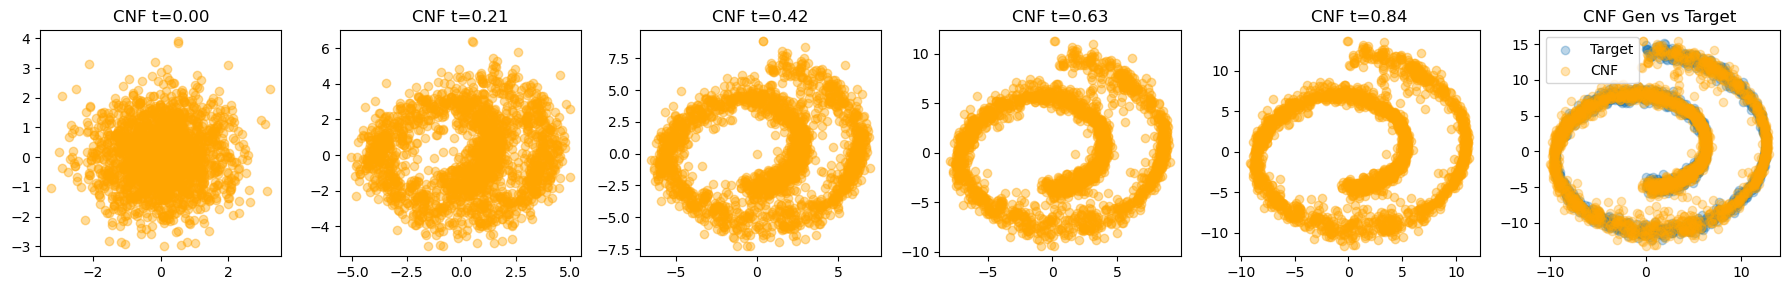

The frechet distance of CNF model is:  0.0377842533818864
The wasserstein distance of CNF model is:  0.1617808425135445


In [8]:
# 8. Main Execution
import time
import psutil
import os
import tracemalloc
import torch.cuda
if __name__ == "__main__":
    # Initialize models
    cnf_model = CNFNet().to(device)



    print("Training Continuous Normalizing Flow...")
    torch.cuda.reset_peak_memory_stats()
    start_time = time.time()
    train_cnf(cnf_model, target_data, epochs= 300)
    cnf_time = time.time() - start_time
    print(cnf_time)



    # Visualize learned transformations
    visualize_cnf(cnf_model, source_data=source_data, target_np=target_np)
    
    




===== Starting Reflow Round 1 =====
[RF-Student] Epoch 0 | Loss: 12.3446
[RF-Student] Epoch 10 | Loss: 1.8350
[RF-Student] Epoch 20 | Loss: 0.2537
[RF-Student] Epoch 30 | Loss: 0.0738
[RF-Student] Epoch 40 | Loss: 0.0148
[RF-Student] Epoch 50 | Loss: 0.0045
[RF-Student] Epoch 60 | Loss: 0.0023
[RF-Student] Epoch 70 | Loss: 0.0017
[RF-Student] Epoch 80 | Loss: 0.0010
[RF-Student] Epoch 90 | Loss: 0.0007
[RF-Student] Epoch 100 | Loss: 0.0006
[RF-Student] Epoch 110 | Loss: 0.0003
[RF-Student] Epoch 120 | Loss: 0.0003
[RF-Student] Epoch 130 | Loss: 0.0004
[RF-Student] Epoch 140 | Loss: 0.0003
[RF-Student] Epoch 150 | Loss: 0.0002
[RF-Student] Epoch 160 | Loss: 0.0002
[RF-Student] Epoch 170 | Loss: 0.0002
[RF-Student] Epoch 180 | Loss: 0.0002
[RF-Student] Epoch 190 | Loss: 0.0002
[RF-Student] Epoch 200 | Loss: 0.0002
[RF-Student] Epoch 210 | Loss: 0.0001
[RF-Student] Epoch 220 | Loss: 0.0001
[RF-Student] Epoch 230 | Loss: 0.0001
[RF-Student] Epoch 240 | Loss: 0.0001
[RF-Student] Epoch 250 

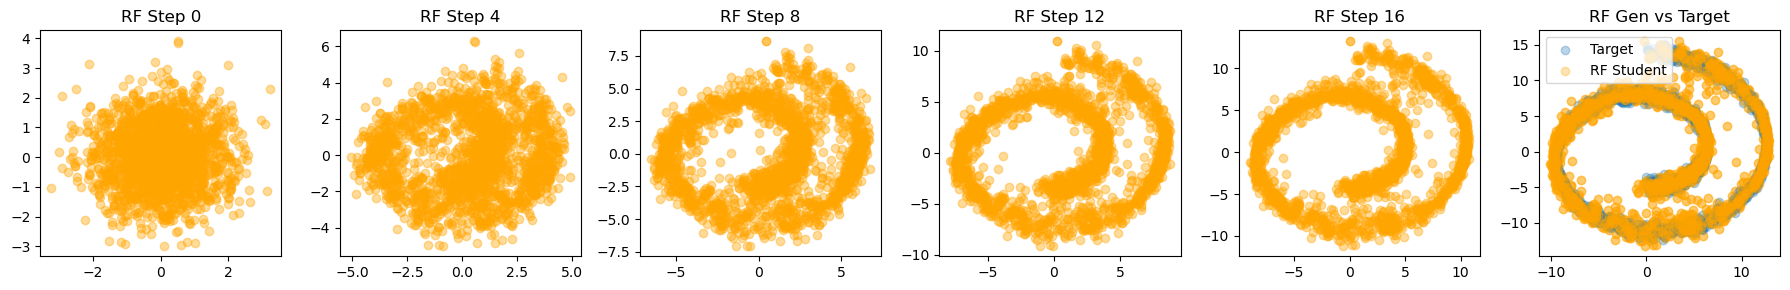

The frechet distance of RF model is:  0.015678993507734162
The wasserstein distance of RF model is:  0.15425210668973155

===== Starting Reflow Round 2 =====
[RF-Student] Epoch 0 | Loss: 13.0872
[RF-Student] Epoch 10 | Loss: 2.0358
[RF-Student] Epoch 20 | Loss: 0.2062
[RF-Student] Epoch 30 | Loss: 0.0566
[RF-Student] Epoch 40 | Loss: 0.0185
[RF-Student] Epoch 50 | Loss: 0.0041
[RF-Student] Epoch 60 | Loss: 0.0018
[RF-Student] Epoch 70 | Loss: 0.0013
[RF-Student] Epoch 80 | Loss: 0.0008
[RF-Student] Epoch 90 | Loss: 0.0005
[RF-Student] Epoch 100 | Loss: 0.0003
[RF-Student] Epoch 110 | Loss: 0.0003
[RF-Student] Epoch 120 | Loss: 0.0003
[RF-Student] Epoch 130 | Loss: 0.0002
[RF-Student] Epoch 140 | Loss: 0.0002
[RF-Student] Epoch 150 | Loss: 0.0002
[RF-Student] Epoch 160 | Loss: 0.0002
[RF-Student] Epoch 170 | Loss: 0.0001
[RF-Student] Epoch 180 | Loss: 0.0001
[RF-Student] Epoch 190 | Loss: 0.0001
[RF-Student] Epoch 200 | Loss: 0.0001
[RF-Student] Epoch 210 | Loss: 0.0001
[RF-Student] Epo

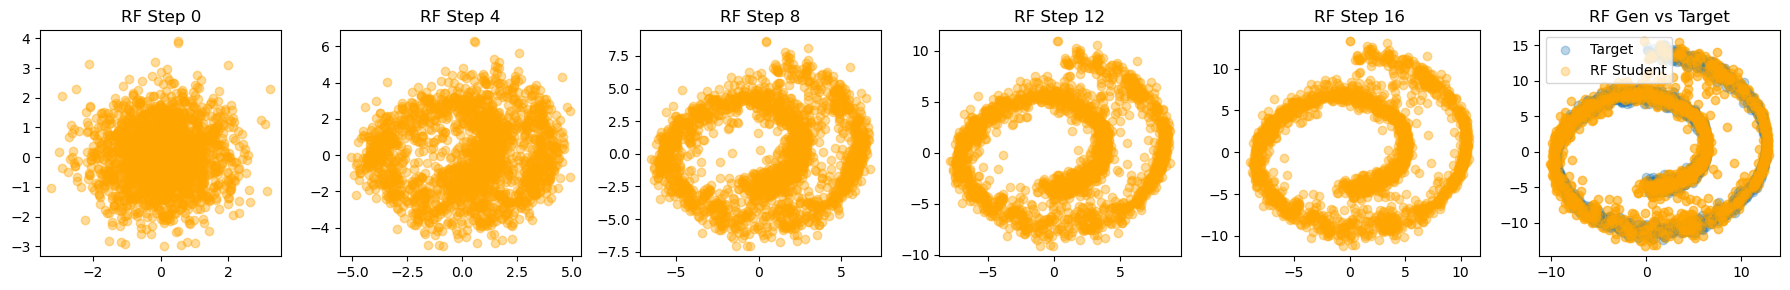

The frechet distance of RF model is:  0.01628193260640387
The wasserstein distance of RF model is:  0.15472608667507298


In [9]:
teacher = cnf_model
for round_idx in range(2):  # 3 rounds of Reflow
    print(f"\n===== Starting Reflow Round {round_idx+1} =====")
    student = train_rf_student(teacher, source_data = source_data, epochs=400, batch_size = 256, lr = 1e-4, num_steps = 50)
    visualize_rf_student(student, source_data = source_data, target_np=target_np)  # Optional: visualize after each round
    teacher = student  # Update teacher


In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model parameter count: {count_parameters(cnf_model)}")
print(f"Model parameter count: {count_parameters(teacher)}")

Model parameter count: 4546
Model parameter count: 4546


In [11]:
# High-precision timing utility for CUDA
def measure_inference_time(model_fn, source_data, repeat=5):
    torch.cuda.synchronize()
    start = time.perf_counter()

    for _ in range(repeat):
        model_fn(source_data)

    torch.cuda.synchronize()
    end = time.perf_counter()

    avg_time = (end - start) / repeat
    return avg_time

# CNF inference function
def cnf_inference(source_data):
    with torch.no_grad():
        t_vals = torch.linspace(0, 1, 20).to(source_data.device)  # Ensure time steps are on the same device
        _ = odeint(cnf_model, source_data, t_vals)

# RF student inference function
def rf_student_inference(source_data):
    with torch.no_grad():
        z = source_data.to(device)
        t = torch.zeros(z.size(0), 1).to(device)
        dt = 1.0 / 20
        for _ in range(20):  # Fixed number of Euler steps
            v = rf_student_model(t.squeeze(1), z)
            z = z + dt * v
            t += dt

# Setup for timing comparison
batch_size = 1000
device = 'cuda' if torch.cuda.is_available() else 'cpu'
rf_student_model = teacher

# Move models to the target device (important!)
cnf_model = cnf_model.to(device)
rf_student_model = rf_student_model.to(device)

# Generate random source inputs
source_data = torch.randn(batch_size, 2).to(device)

# Measure average inference time
cnf_time = measure_inference_time(cnf_inference, source_data)
rf_time = measure_inference_time(rf_student_inference, source_data)

print(f"Average CNF inference time: {cnf_time * 1000:.2f} ms")
print(f"Average RF Student inference time: {rf_time * 1000:.2f} ms")

Average CNF inference time: 230.26 ms
Average RF Student inference time: 7.70 ms
